In [108]:
# Import libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone


# Load the cleaned data from EDA
cleaned_data_path = "../data/processed/features_emg_data_cleaned.csv"
df_no_outliers = pd.read_csv(cleaned_data_path)
print(f"Loaded cleaned data: {df_no_outliers.shape}")

# Define feature columns (same logic as before)
metadata_cols = ['user', 'gesture', 'stage', 'is_outlier']
all_columns = df_no_outliers.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]
print(f"Feature columns: {len(feature_cols)}")

Loaded cleaned data: (135299, 164)
Feature columns: 160


In [109]:
RANDOM_STATE = 13
PERSONALIZATION_K = 5 # Folds per user for within-user evaluation

# Define primary & secondary metrics
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [110]:
# Personalization split: 80% train/calibration, 20% test PER USER, stratified by stage and gesture
# CRITICAL: Split data BEFORE feature selection to prevent data leakage
# Ensures test data doesn't influence which features we select

# add a column containing both stage and gesture
df_no_outliers['stage_gesture'] = df_no_outliers['stage']+'__'+df_no_outliers['gesture']

# identify user-stage-gesture combinations with limited data points.
# create a new column containing this information, with default value 'many', which will be updated in the next step
df_no_outliers['how_many_stage_gesture'] = 'many'

# check for user-stage-gesture combinations with fewer than 5 data points, and update 'how_many_stage_gesture' column
for user_id in df_no_outliers['user'].unique():
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    for stage_gesture_name in user_data['stage_gesture'].unique():
        if 1 < user_data['stage_gesture'].value_counts()[stage_gesture_name] < 5:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'few'
        if user_data['stage_gesture'].value_counts()[stage_gesture_name] == 1:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'one'

# separate the data into three frames 
df_one_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'one']
df_few_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'few']
df_many_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'many']

# now we are ready to split the data
train_pieces, test_pieces = [], []

# split df_few_stage_gesture by keeping 1 data point for testing from each user-stage-gesture combination 
for user_id in df_few_stage_gesture['user'].unique():
    user_data = df_few_stage_gesture[df_few_stage_gesture['user'] == user_id]
    
    for stage_gesture in user_data.stage_gesture.unique():
        user_train = user_data[user_data['stage_gesture'] == stage_gesture].iloc[1:,:]
        user_test = user_data[user_data['stage_gesture'] == stage_gesture].iloc[[0]]
    
        train_pieces.append(user_train)
        test_pieces.append(user_test)

# split df_many_stage_gesture for each user, stratifying by stage and gesture 
for user_id in df_many_stage_gesture['user'].unique():
    user_data = df_many_stage_gesture[df_many_stage_gesture['user'] == user_id]
    
    # Split: 80% train, 20% test
    user_train, user_test = train_test_split(
        user_data, test_size=0.2, random_state=13, shuffle=True, stratify=user_data.stage_gesture
    )
    
    train_pieces.append(user_train)
    test_pieces.append(user_test)

# Combine all pieces
df_train = pd.concat(train_pieces+[df_one_stage_gesture])
df_test = pd.concat(test_pieces)

# remove 'stage_gesture' and 'how_many_stage_gesture' columns
df_no_outliers = df_no_outliers.drop(columns=['stage_gesture','how_many_stage_gesture'])
df_train = df_train.drop(columns=['stage_gesture','how_many_stage_gesture'])
df_test = df_test.drop(columns=['stage_gesture','how_many_stage_gesture'])

print(f"Original: {df_no_outliers.shape}")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Original: (135299, 164)
Train: (108187, 164)
Test: (27112, 164)


In [111]:
# Calculate feature importance for EACH USER individually
all_user_results = {}

for user_id in df_train['user'].unique():
    # Get this user's data only
    user_data = df_train[df_train['user'] == user_id]
    
    # Prepare features and target for this user
    X_user = user_data[feature_cols].copy()
    y_user = user_data['gesture']
    
    # Train Random Forest for this specific user
    rf_user = RandomForestClassifier(
        n_estimators=100,
        random_state=13,
        # max_depth=15,
        n_jobs=-1
    )
    rf_user.fit(X_user, y_user)
    
    # Get feature importance for this user
    user_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_user.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Store results
    all_user_results[user_id] = user_importance_df
    
    # Clean up
    del X_user, y_user, rf_user

In [112]:
# Build per_user_stats_df
feature_importance_stats = {}

for feature in feature_cols:
    scores = []
    for user_id, user_imp_df in all_user_results.items():
        s = user_imp_df.loc[user_imp_df['feature'] == feature, 'importance']
        if len(s) > 0:
            scores.append(float(s.iloc[0]))

    if len(scores) > 0:
        scores = np.asarray(scores, dtype=float)
        mean_val   = float(np.mean(scores))
        median_val = float(np.median(scores))
        std_val    = float(np.std(scores, ddof=0))
        n_scored   = int(len(scores))
    else:
        # keep row to avoid downstream NaNs
        mean_val   = 0.0
        median_val = 0.0
        std_val    = 0.0
        n_scored   = 0

    feature_importance_stats[feature] = {
        'mean':   mean_val,
        'median': median_val,
        'std':    std_val,
        'n_users_with_score': n_scored
    }

per_user_stats_df = pd.DataFrame.from_dict(feature_importance_stats, orient='index')

# Preview
per_user_stats_df.head()

,mean,median,std,n_users_with_score
ch00_rms,0.007816,0.007247,0.002844,100
ch01_rms,0.008050,0.007368,0.003236,100
ch02_rms,0.010236,0.008854,0.005791,100
ch03_rms,0.013725,0.012061,0.006518,100
ch04_rms,0.016798,0.016100,0.007060,100


In [113]:
# Starting pool: how many top features to consider before redundancy removal
STARTING_POOL_SIZE = 75

# Correlation threshold: features with correlation above this will be considered redundant
CORRELATION_THRESHOLD = 0.9

In [114]:
# Personalized / per-user correlation analysis of top features — PERSONALIZED

# Build personalized train-only correlation matrix
user_corrs = []
for uid in sorted(df_train['user'].unique()):
    sub = df_train[df_train['user'] == uid]
    if len(sub) > 3:
        user_corrs.append(sub[feature_cols].corr().values)

corr_arr = np.nanmean(np.stack(user_corrs, axis=0), axis=0)
corr_df = pd.DataFrame(corr_arr, index=feature_cols, columns=feature_cols)

# Choose ranking column (personalization-first uses MEDIAN)
rank_col = 'median' if 'median' in per_user_stats_df.columns else 'mean'

# Top N by personalized importance (N = STARTING_POOL_SIZE)
topN_features = (
    per_user_stats_df
    .sort_values(rank_col, ascending=False)
    .head(STARTING_POOL_SIZE)
    .index
    .tolist()
)

# Personalized correlation among top-N (use the SAME corr_df as pruning)
correlation_matrix = corr_df.loc[topN_features, topN_features]

# Find highly correlated pairs (r > CORRELATION_THRESHOLD)
high_corr_pairs = []
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        corr_value = abs(float(correlation_matrix.iloc[i, j]))
        if corr_value > CORRELATION_THRESHOLD:
            high_corr_pairs.append((cols[i], cols[j], corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > {CORRELATION_THRESHOLD})")
if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")


Found: 87 highly correlated feature pairs (r > 0.9)
Some highly correlated features:
  ch05_rms <-> ch05_maxabs: 0.955
  ch05_rms <-> ch05_mav: 0.987
  ch05_rms <-> ch05_fft-maxpower: 0.926
  ch04_rms <-> ch04_maxabs: 0.958
  ch04_rms <-> ch04_mav: 0.986


In [115]:
# Personalized redundancy pruning (do NOT rebuild corr_df)

# Keep only features that appear in correlation matrix
stats_tbl = per_user_stats_df.copy()
common_idx = stats_tbl.index.intersection(corr_df.index)
stats_tbl = stats_tbl.loc[common_idx].copy()

# Choose ranking column: prefer 'median' (more robust per-user), else fall back to 'mean'
rank_col = 'median' if 'median' in stats_tbl.columns else 'mean'

# Seed list: top-N by personalized importance (N = STARTING_POOL_SIZE)
top_features = (
    stats_tbl
    .sort_values(rank_col, ascending=False)
    .head(int(STARTING_POOL_SIZE))
    .index
    .tolist()
)

# Pruning: if candidate is highly correlated with anything already kept,
# keep the one with higher personalized importance (by rank_col)
final_features = []

for f in top_features:
    keep_f = True
    for g in final_features:
        # If either feature missing from corr_df, treat as uncorrelated
        if (f in corr_df.index and g in corr_df.index and
            f in corr_df.columns and g in corr_df.columns):
            rho = float(abs(corr_df.loc[f, g]))
        else:
            rho = 0.0

        if rho > float(CORRELATION_THRESHOLD):
            # Conflict: keep higher-ranked by rank_col
            if float(stats_tbl.loc[f, rank_col]) > float(stats_tbl.loc[g, rank_col]):
                # Replace g with f
                final_features.remove(g)
                final_features.append(f)
                print(f" Replaced {g} with {f} (|r|={rho:.2f} > {CORRELATION_THRESHOLD}; {rank_col} improved)")
            # Either way, we've handled f vs g; don't add f again
            keep_f = False
            break

    if keep_f and f not in final_features:
        final_features.append(f)

print(f"{len(final_features)} features after removing redundant features "
      f"(seed={len(top_features)}, thr={CORRELATION_THRESHOLD}, rank={rank_col}).")

# Category summary for sanity checking
feature_categories = {
    'FFT Features': [],
    'RMS Features': [],
    'MAV Features': [],
    'Max Features': [],
    'Threshold Features': []
}
for feat in final_features:
    fl = feat.lower()
    if 'fft' in fl:
        feature_categories['FFT Features'].append(feat)
    elif 'rms' in fl:
        feature_categories['RMS Features'].append(feat)
    elif 'mav' in fl:
        feature_categories['MAV Features'].append(feat)
    elif 'max' in fl:
        feature_categories['Max Features'].append(feat)
    elif 'thresh' in fl:
        feature_categories['Threshold Features'].append(feat)

for cat, feats in feature_categories.items():
    if feats:
        print(f"\n{cat} ({len(feats)}):")
        for feat in sorted(feats):
            print(f"  - {feat} (importance={stats_tbl.loc[feat, rank_col]:.4f})")

cols_keep = ['user', 'gesture', 'stage'] + list(final_features)
df_train_selected_features = df_train[cols_keep].copy()

32 features after removing redundant features (seed=75, thr=0.9, rank=median).

FFT Features (5):
  - ch03_fft-maxpower (importance=0.0081)
  - ch05_fft-highfreq (importance=0.0046)
  - ch06_fft-highfreq (importance=0.0047)
  - ch09_fft-maxpower (importance=0.0082)
  - ch11_fft-maxpower (importance=0.0082)

RMS Features (11):
  - ch00_rms (importance=0.0072)
  - ch02_rms (importance=0.0089)
  - ch04_rms (importance=0.0161)
  - ch05_rms (importance=0.0163)
  - ch06_rms (importance=0.0118)
  - ch08_rms (importance=0.0093)
  - ch10_rms (importance=0.0109)
  - ch12_rms (importance=0.0091)
  - ch13_rms (importance=0.0094)
  - ch14_rms (importance=0.0096)
  - ch15_rms (importance=0.0096)

MAV Features (2):
  - ch01_mav (importance=0.0067)
  - ch07_mav (importance=0.0099)

Max Features (5):
  - ch01_maxabs (importance=0.0075)
  - ch03_maxabs (importance=0.0123)
  - ch07_maxabs (importance=0.0072)
  - ch09_maxabs (importance=0.0088)
  - ch11_maxabs (importance=0.0077)

Threshold Features (9):


# Modeling

In [116]:
TARGET = 'gesture'
GROUP = 'user'
# 'stage' included as metadata
metadata_cols = [GROUP, TARGET, 'stage'] 
final_features = [col for col in df_train_selected_features.columns if col not in metadata_cols]

X = df_train_selected_features[final_features]
y_raw = df_train_selected_features[TARGET]
groups = df_train_selected_features[GROUP]

# Encode target labels
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_raw), index=y_raw.index)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Unique users (groups): {groups.nunique()}, Unique gestures: {y.nunique()}")

# Create label mapping using original encoder from data loading
# already encoded y_raw to y, so use same encoder
class_names = le.classes_

# dataframe for label mapping
label_mapping_df = pd.DataFrame({
    'Encoded_label': range(len(class_names)),
    'Gesture_Class': class_names
})

X shape: (108187, 32), y shape: (108187,)
Unique users (groups): 100, Unique gestures: 9


In [117]:
# LOAD FULL FEATURE SETS FOR REGULARIZED MODELS 
df_train_full = df_train

# Define full feature set (160 features)
full_features = [col for col in df_train_full.columns if col not in metadata_cols]

# Create full feature datasets
X_full = df_train_full[full_features]

In [118]:
# DEFINE MODELS TO TEST, INCL CLASS IMBALANCE & FEATURE STRATEGIES

# Define reusable preprocessing pipeline step, log transform is to address the right-skewness of our data
preprocessor = Pipeline([('log_transform', FunctionTransformer(np.log1p)),('scaler', StandardScaler())])

models_to_test = {
    'DummyClassifier': Pipeline([
        ('prep', preprocessor),
        ('clf', DummyClassifier(strategy='stratified', random_state=RANDOM_STATE))
    ]),
    'Logit_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE
        ))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=100, max_depth=6, random_state=RANDOM_STATE, n_jobs=1,
            class_weight='balanced'  # for imbalance
        ))
    ]),
    # Class-weighted logistic regression on selected features
    'Logit_Weighted_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            class_weight='balanced'  # to address imbalance 
        ))
    ]),
    # Class-weighted logistic regression on all 160 features
    'Logit_Weighted_All_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            class_weight='balanced',  # Combine high-dimensional features w/ class balancing
            C=0.1  # STRONGER REGULARIZATION?
        ))
    ]),
    # Standard logistic regression on all 160 features
    'Logit_All_L2': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='lbfgs', 
            max_iter=1000, 
            random_state=RANDOM_STATE,
            C=0.1  # STRONGER REGULARIZATION?
        ))
    ])
}

# Define which models use which feature set
model_feature_mapping = {
    'Logit_All_L2': X_full,
    'Logit_Weighted_All_L2': X_full,
}

In [119]:
# Cache directory for model results
import joblib
from pathlib import Path
CACHE_DIR = Path("../cache")
CACHE_DIR.mkdir(exist_ok=True)

def run_personalization_cv(model, X, y, groups, name, k_folds, scoring_metrics, use_cache=True):
    """
    Evaluates model performance averaged across all users using StratifiedKFold within each user.
    Returns both aggregate results and per-user results for swarm plot visualization.
    """
    
    # Create a unique identifier for this specific model configuration
    model_params = model.named_steps['clf'].get_params(deep=False)
    data_shape = X.shape
    config_hash = joblib.hash({'name': name, 'params': model_params, 'data_shape': data_shape, 'k_folds': k_folds})
    
    cache_file = CACHE_DIR / f"personalization_{config_hash}.pkl"
    user_results_cache_file = CACHE_DIR / f"personalization_{config_hash}_user_results.pkl"

    # Return cached results if available
    if use_cache and cache_file.exists() and user_results_cache_file.exists():
        print(f"  Loading cached results for {name}...")
        aggregate_result = joblib.load(cache_file)
        user_results_df = joblib.load(user_results_cache_file)
        return aggregate_result, user_results_df

    print(f"Evaluating {name} for personalization...")

    unique_users = groups.unique()
    all_f1_scores = []
    all_acc_scores = []
    users_evaluated = 0
    users_skipped = 0
    
    # Store per-user results for swarm plot
    per_user_results = []

    cv_splitter = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=RANDOM_STATE)

    for user in unique_users:
        # Isolate data for current user
        user_indices = groups[groups == user].index
        X_user = X.loc[user_indices]
        y_user = y.loc[user_indices]

        # Ensure sufficient samples & classes for StratifiedKFold
        if len(y_user.unique()) < k_folds:
            print(f"Warning: Skipping user {user} (N={len(y_user)}) due to insufficient classes for {k_folds}-fold CV")
            users_skipped += 1
            continue

        # Clone model to ensure fresh fit for ea user
        user_model = clone(model)

        # Cross-validation w/i current user's data
        f1_scores = cross_val_score(
            user_model, X_user, y_user, cv=cv_splitter, scoring=scoring_metrics['f1_macro']
        )
        acc_scores = cross_val_score(
            user_model, X_user, y_user, cv=cv_splitter, scoring=scoring_metrics['accuracy']
        )

        all_f1_scores.extend(f1_scores)
        all_acc_scores.extend(acc_scores)
        users_evaluated += 1
        
        # Capture per-user metrics for swarm plot
        user_mean_accuracy = np.mean(acc_scores)
        user_sample_count = len(X_user)
        
        per_user_results.append({
            'Model': name,
            'User_ID': user,
            'Mean_User_Accuracy': user_mean_accuracy,
            'Sample_Count': user_sample_count,
            'Folds_Processed': len(acc_scores)
        })

    # Calc overall mean & stdev across all folds
    mean_f1 = np.mean(all_f1_scores)
    std_f1 = np.std(all_f1_scores)
    mean_acc = np.mean(all_acc_scores)
    std_acc = np.std(all_acc_scores)

    # Extract hyperparams
    hyperparams = model.named_steps['clf'].get_params(deep=False)

    aggregate_result = {
        'Model': name,
        'Mean_Accuracy': mean_acc,
        'Std_Accuracy': std_acc,
        'Mean_F1_Macro': mean_f1,
        'Std_F1_Macro': std_f1,
        'Hyperparameters': str(hyperparams),
        'N_Users_Evaluated': users_evaluated,
        'N_Users_Skipped': users_skipped,
        'Total_Folds': len(all_f1_scores),
        'Config_Hash': config_hash
    }
    
    # Create per-user results df
    user_results_df = pd.DataFrame(per_user_results)

    print(f"{name}: {users_evaluated} users evaluated, {users_skipped} skipped")
    
    # Cache both aggregate & per-user results
    if use_cache:
        joblib.dump(aggregate_result, cache_file)
        joblib.dump(user_results_df, user_results_cache_file)
        print(f"Cached results for {name} with hash {config_hash}")

    return aggregate_result, user_results_df

In [120]:
# Define which models use which feature set
model_feature_mapping = {
    'Logit_All_L2': X_full,
    'Logit_Weighted_All_L2': X_full,
}

# Use personalization eval w/ caching
results = []
all_user_results = []  # Collect per-user results from all models

for name, model in models_to_test.items():
    # Select appropriate feature set for each model
    if name in model_feature_mapping:
        X_model = model_feature_mapping[name]
        feature_type = "full features"
    else:
        X_model = X  # Default to selected feats
        feature_type = "selected features"
    
    print(f"Evaluating {name} with {feature_type} ({X_model.shape[1]} features)")
    
    res, user_res = run_personalization_cv(model, X_model, y, groups, name, PERSONALIZATION_K, scoring_metrics, use_cache=True)
    results.append(res)
    all_user_results.append(user_res)  # Collect per-user results

# Combine all per-user results into single df for swarm plot
user_performance_df = pd.concat(all_user_results, ignore_index=True)

results_df = pd.DataFrame(results).sort_values(by='Mean_F1_Macro', ascending=False)
results_df

Evaluating DummyClassifier with selected features (32 features)
  Loading cached results for DummyClassifier...
Evaluating Logit_L2 with selected features (32 features)
  Loading cached results for Logit_L2...
Evaluating RandomForest with selected features (32 features)
  Loading cached results for RandomForest...
Evaluating Logit_Weighted_L2 with selected features (32 features)
  Loading cached results for Logit_Weighted_L2...
Evaluating Logit_Weighted_All_L2 with full features (161 features)
Evaluating Logit_Weighted_All_L2 for personalization...
Logit_Weighted_All_L2: 100 users evaluated, 0 skipped
Cached results for Logit_Weighted_All_L2 with hash d1a5e71fefb5075ca129e15ad125533c
Evaluating Logit_All_L2 with full features (161 features)
Evaluating Logit_All_L2 for personalization...
Logit_All_L2: 100 users evaluated, 0 skipped
Cached results for Logit_All_L2 with hash 1a23a44bf9433a0db9d08dadd9d69e8c


,Model,Mean_Accuracy,Std_Accuracy,Mean_F1_Macro,Std_F1_Macro,Hyperparameters,N_Users_Evaluated,N_Users_Skipped,Total_Folds,Config_Hash
5,Logit_All_L2,0.724775,0.126069,0.701763,0.124233,"{'C': 0.1, 'class_weight': None, 'dual': False...",100,0,500,1a23a44bf9433a0db9d08dadd9d69e8c
4,Logit_Weighted_All_L2,0.722285,0.126437,0.700416,0.124113,"{'C': 0.1, 'class_weight': 'balanced', 'dual':...",100,0,500,d1a5e71fefb5075ca129e15ad125533c
1,Logit_L2,0.713849,0.118159,0.692185,0.117145,"{'C': 1.0, 'class_weight': None, 'dual': False...",100,0,500,4f5c789368c7fa0d0cde584947020642
3,Logit_Weighted_L2,0.708153,0.117197,0.688182,0.117169,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",100,0,500,f4b016ce024facef7044a10c2584a9a3
2,RandomForest,0.639462,0.119342,0.609973,0.112875,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",100,0,500,d10b7fb629b0b05b8ba4f9d14e854e9b
0,DummyClassifier,0.146502,0.043680,0.108575,0.022345,"{'constant': None, 'random_state': 13, 'strate...",100,0,500,02f2e699c4aed6d918c5f2877481eb47


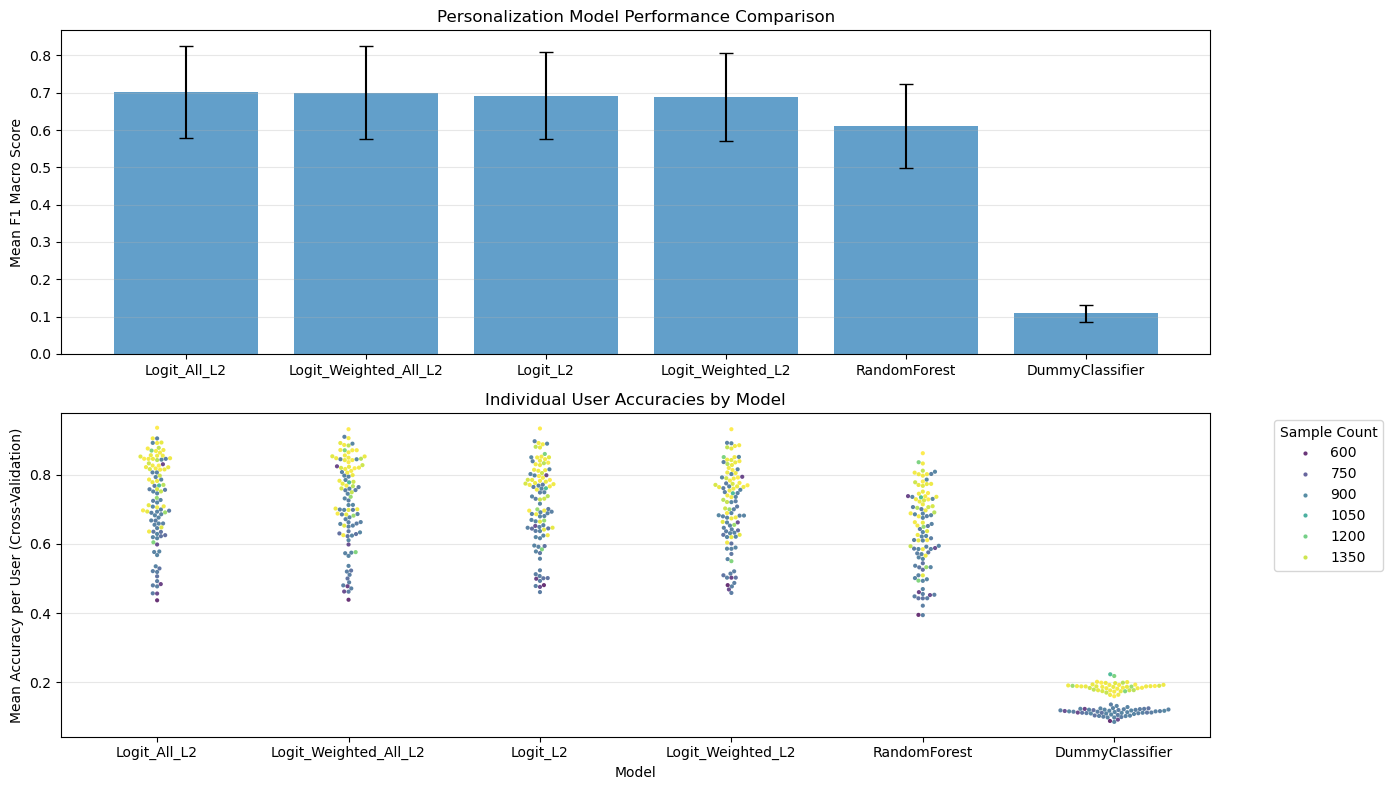

In [121]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Get model order from results_df (sorted by performance)
model_order = results_df['Model'].tolist()

# Subplot: Model performance comparison
bars = ax1.bar(results_df['Model'], results_df['Mean_F1_Macro'], 
               yerr=results_df['Std_F1_Macro'], capsize=5, alpha=0.7)
ax1.set_ylabel('Mean F1 Macro Score')
ax1.set_title('Personalization Model Performance Comparison')
ax1.grid(axis='y', alpha=0.3)
# ax1.tick_params(axis='x', rotation=45)

# Subplot: Swarm plot
swarm_plot = sns.swarmplot(
    x='Model', 
    y='Mean_User_Accuracy', 
    hue='Sample_Count', 
    data=user_performance_df, 
    size=3,  # Reduced from 4 to minimize overlap
    palette='viridis',
    alpha=0.8,
    ax=ax2,
    order=model_order  # same order as bar plot
)
ax2.set_ylabel('Mean Accuracy per User (Cross-Validation)')
# ax2.set_xlabel('Model')
ax2.set_title('Individual User Accuracies by Model')
ax2.legend(title='Sample Count', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, axis='y', alpha=0.3)
# ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()